In [1]:
%matplotlib widget
from preprocessing_utils import make_probe_plots, standard_preprocessing
from nwb_conv.oephys import OEPhysDataFolder
import spikeinterface.extractors as se
from matplotlib import pyplot as plt
import numpy as np
from spikeinterface.sortingcomponents.peak_detection import detect_peaks

base_npxpaths = [r"D:\M31-npx"]

run_preprocessing = True # run preprocessing and spikesorting
callKSfromSI = False  # this remains insanely slow.

In [2]:
?detect_peaks

Signature:
detect_peaks(
    recording,
    method='locally_exclusive',
    pipeline_nodes=None,
    gather_mode='memory',
    folder=None,
    names=None,
    **kwargs,
)
Docstring:
Peak detection based on threshold crossing in term of k x MAD.

In "by_channel" : peak are detected in each channel independently
In "locally_exclusive" : a single best peak is taken from a set of neighboring channels

Parameters
----------
recording: RecordingExtractor
    The recording extractor object.
pipeline_nodes: None or list[PipelineNode]
    Optional additional PipelineNode need to computed just after detection time.
    This avoid reading the recording multiple times.
gather_mode: str
    How to gather the results:
    * "memory": results are returned as in-memory numpy arrays
    * "npy": results are stored to .npy files in `folder`

folder: str or Path
    If gather_mode is "npy", the folder where the files are created.
names: list
    List of strings with file stems associated with returns.



In [3]:
oe_data_folder = OEPhysDataFolder(base_npxpaths[0])

for stream_name in oe_data_folder.ap_stream_names[1:]:    
    # print("new dir: ", ks_folder)
    recording_raw = se.read_openephys(folder_path=oe_data_folder.path, 
                                      stream_name=stream_name, load_sync_channel=False) # this maps all streams even if you specify only one
    print("Stream name: ", recording_raw.stream_name)
    print(recording_raw)

    fs = recording_raw.get_sampling_frequency()

    # recording_preprocessed = standard_preprocessing(recording_raw)

Stream name:  Record Node 107#Neuropix-PXI-100.ProbeB-AP
OpenEphysBinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 193,516,752 samples 
                                   6,450.56s (1.79 hours) - int16 dtype - 138.41 GiB


In [14]:
import spikeinterface.preprocessing as st
import spikeinterface.full as si

def standard_preprocessing(recording):
    """Aggregate lab standard preprocessing steps for Neuropixels data."""

    # recording = st.correct_lsb(recording, verbose=1)
    # recording = st.bandpass_filter(recording, freq_min=300, freq_max=6000)
    recording = st.phase_shift(recording) #lazy
    # [bad_channel_ids, channel_labels] = st.detect_bad_channels(recording=recording)  
    # recording = recording.remove_channels(remove_channel_ids=bad_channel_ids)  # could be interpolated instead, but why?

    # split in groups and apply spatial filtering, then reaggregate. KS4 can now handle multiple shanks
    if recording.get_probes()[0].get_shank_count() > 1:
        grouped_recordings = recording.split_by(property='group')
        recgrouplist = [st.highpass_spatial_filter(recording=grouped_recordings[k]) for k in grouped_recordings.keys()]  # cmr is slightly faster. results are similar
        recording = si.aggregate_channels(recgrouplist)
    
    else:
        recording = st.highpass_spatial_filter(recording=recording)

    return recording

recording_preprocessed = standard_preprocessing(recording_raw)
window_t_s = 2
window_size_pts = int(window_t_s * fs)
start_time = 24.5
start_t_pts = int(start_time * fs)
chans = recording_raw.channel_ids[[50, 100, 150]]
arr_raw = recording_raw.get_traces(start_frame=start_t_pts, 
                         end_frame=start_t_pts + window_size_pts, 
                         channel_ids=chans)
arr_preprocessed = recording_preprocessed.get_traces(start_frame=start_t_pts,
                                                        end_frame=start_t_pts + window_size_pts,
                                                        channel_ids=chans)

time = np.arange(0, window_t_s, 1/fs)

In [8]:
peaks = detect_peaks(recording_raw,
                     method='locally_exclusive',
                     radius_um=1000,
                     exclude_sweep_ms=100,
                     peak_sign='both',
                     detect_threshold=25,
                     noise_levels=None,
                     chunk_memory = '50M',
                     n_jobs = -1,
                     progress_bar=True)

detect peaks using locally_exclusive:   0%|          | 0/2973 [00:00<?, ?it/s]

In [20]:
arr = np.array([(i) for i, ch, _, _ in peaks])

# drop all within the same 300 samples window:
arr = arr[1:][np.diff(arr) > 300]
len(arr)

23705

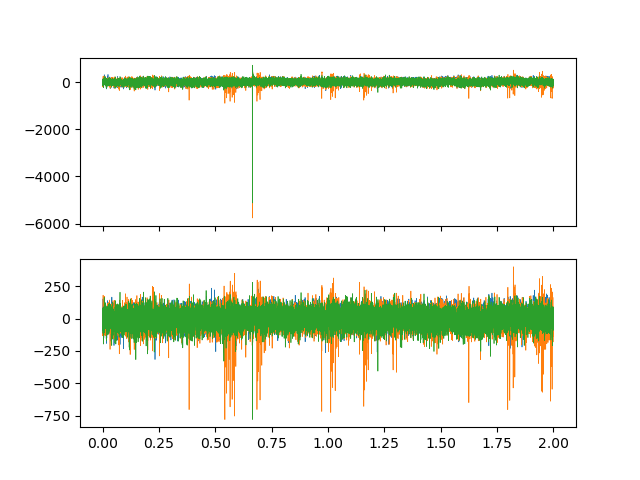

In [15]:
f, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(time, arr_raw, lw=0.5)
axs[1].plot(time, arr_preprocessed, lw=0.5)

In [13]:
window_t_s = 0.0
window_size_pts = int(window_t_s * fs)
start_time = 20
start_t_pts = int(start_time * fs)
chans = recording_raw.channel_ids[[50, 100, 150, 200]]
arr_raw = recording_raw.get_traces(start_frame=start_t_pts, 
                         end_frame=start_t_pts + window_size_pts, 
                         channel_ids=chans)
arr_preprocessed = recording_preprocessed.get_traces(start_frame=start_t_pts,
                                                        end_frame=start_t_pts + window_size_pts,
                                                        channel_ids=chans)

time = np.arange(0, window_t_s, 1/fs)

NameError: name 'recording_preprocessed' is not defined